In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [54]:
df = pd.read_csv("../Life Expectancy Data.csv")


# Removing NaN Values
print(f"Original rows: {len(df)}")
df = df.dropna(subset=["Life expectancy "]) # dropping rows with no target value
print(f"After dropping NaN targets: {len(df)}")

Original rows: 2938
After dropping NaN targets: 2928


In [55]:
X = df.drop(columns=["Life expectancy ", "Status"])
y = df["Life expectancy "]

In [56]:
print(df.columns)

Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')


In [57]:
from sklearn.preprocessing import LabelEncoder

# Drop Status and target columns
X = df.drop(columns=["Life expectancy ", "Status"])

# Impute NaN in features FIRST
imputer = SimpleImputer(strategy='mean')
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
X[numeric_cols] = imputer.fit_transform(X[numeric_cols])

# Encode Country as numeric values
le = LabelEncoder()
X['Country'] = le.fit_transform(X['Country'])

# Normalization
scaler = StandardScaler()
X = scaler.fit_transform(X)

y_scaler = StandardScaler()
y = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

In [58]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [59]:
# Converting from numpy arrays to pytorch tensors

X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train).reshape(-1, 1)
y_val = torch.FloatTensor(y_val).reshape(-1, 1)
y_test = torch.FloatTensor(y_test).reshape(-1, 1)

In [60]:
class MLPRegressor(nn.Module):
    def __init__(self, dropout_rate=0.1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(20, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(dropout_rate), 
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.model(x)

In [61]:
model = MLPRegressor()
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_rmse_history = []
val_rmse_history = []

# Training loop
for epoch in range(250):
    model.train() # setting the model to the training mode
    optimizer.zero_grad()
    
    output = model(X_train)
    loss = loss_function(output, y_train) # calculating the loss
    loss.backward() # calculating the backward pass
    optimizer.step() # updating the weights

    train_rmse = torch.sqrt(loss).item()
    train_rmse_history.append(train_rmse)

    # Validation
    model.eval() # setting the model to the validation mode
    with torch.no_grad():
        output = model(X_val)
        val_loss = loss_function(output, y_val)
        val_rmse = torch.sqrt(val_loss).item()
        val_rmse_history.append(val_rmse)

    if epoch % 10 == 0: # prints every 10 epochs
        print(f"Epoch {epoch}: train_loss={loss.item():.4f}, val_loss={val_loss.item():.4f}")

Epoch 0: train_loss=0.9775, val_loss=1.0183
Epoch 10: train_loss=0.8231, val_loss=0.8572
Epoch 20: train_loss=0.6686, val_loss=0.6925
Epoch 30: train_loss=0.5216, val_loss=0.5240
Epoch 40: train_loss=0.3995, val_loss=0.3834
Epoch 50: train_loss=0.3237, val_loss=0.2955
Epoch 60: train_loss=0.2806, val_loss=0.2386
Epoch 70: train_loss=0.2392, val_loss=0.2010
Epoch 80: train_loss=0.2100, val_loss=0.1795
Epoch 90: train_loss=0.1892, val_loss=0.1683
Epoch 100: train_loss=0.1766, val_loss=0.1619
Epoch 110: train_loss=0.1761, val_loss=0.1560
Epoch 120: train_loss=0.1701, val_loss=0.1489
Epoch 130: train_loss=0.1620, val_loss=0.1433
Epoch 140: train_loss=0.1597, val_loss=0.1388
Epoch 150: train_loss=0.1545, val_loss=0.1348
Epoch 160: train_loss=0.1514, val_loss=0.1318
Epoch 170: train_loss=0.1519, val_loss=0.1276
Epoch 180: train_loss=0.1438, val_loss=0.1249
Epoch 190: train_loss=0.1376, val_loss=0.1216
Epoch 200: train_loss=0.1415, val_loss=0.1187
Epoch 210: train_loss=0.1352, val_loss=0.1161

In [62]:
print(f"Final train RMSE: {train_rmse_history[-1]:.4f}")
print(f"Final val RMSE: {val_rmse_history[-1]:.4f}")

Final train RMSE: 0.3499
Final val RMSE: 0.3256


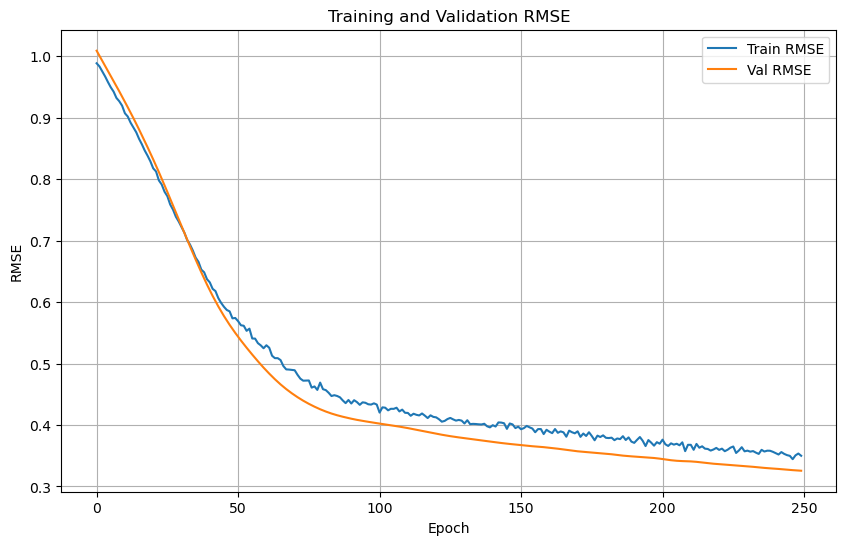

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_rmse_history, label='Train RMSE')
plt.plot(val_rmse_history, label='Val RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Training and Validation RMSE')
plt.legend()
plt.grid(True)
plt.show()